In [2]:
import numpy as np
import pandas as pd
import h5py
from affinewarp import PiecewiseWarping
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import seaborn as sns


In [78]:
Spk =  h5py.File("F:/ComSub/code/ComSub-master/mytry/Spk.mat","r")

time_of_spikecounts = np.array(Spk['Spk']['timeBinMidPoints']).ravel()
spikeCountMatrix = np.array(Spk['Spk']['spikeCountMatrix'])
print(time_of_spikecounts)
print(spikeCountMatrix.shape)


[  205.72776667   205.77776667   205.82776667 ... 30585.87776667
 30585.92776667 30585.97776667]
(607606, 224)


,time,vel,lindist,tperf_timewise,region,traj,trajbound,rewarded,X,Y,...,leftright,future,previous,directional_lindist,trajall,trajectory_type,min,max,percent_time_progress,lindist_binned
44,2003.263067,5.478980,0.0,0.5262,1,1,0,1,77.299239,102.104667,...,1,2.0,NaN,0.0,1,2,2001.013367,2099.363767,0.022874,0
45,2003.333767,5.550389,0.0,0.5262,1,1,0,1,77.359301,101.924483,...,1,2.0,NaN,0.0,1,2,2001.013367,2099.363767,0.023593,0
48,2003.473667,6.510852,0.0,0.5262,1,1,0,1,76.998932,101.804360,...,1,2.0,NaN,0.0,1,2,2001.013367,2099.363767,0.025016,0
49,2003.543733,5.199091,0.0,0.5262,1,1,0,1,77.179116,101.684236,...,1,2.0,NaN,0.0,1,2,2001.013367,2099.363767,0.025728,0
50,2003.573800,7.090353,0.0,0.5262,1,1,0,1,77.058993,101.504052,...,1,2.0,NaN,0.0,1,2,2001.013367,2099.363767,0.026034,0


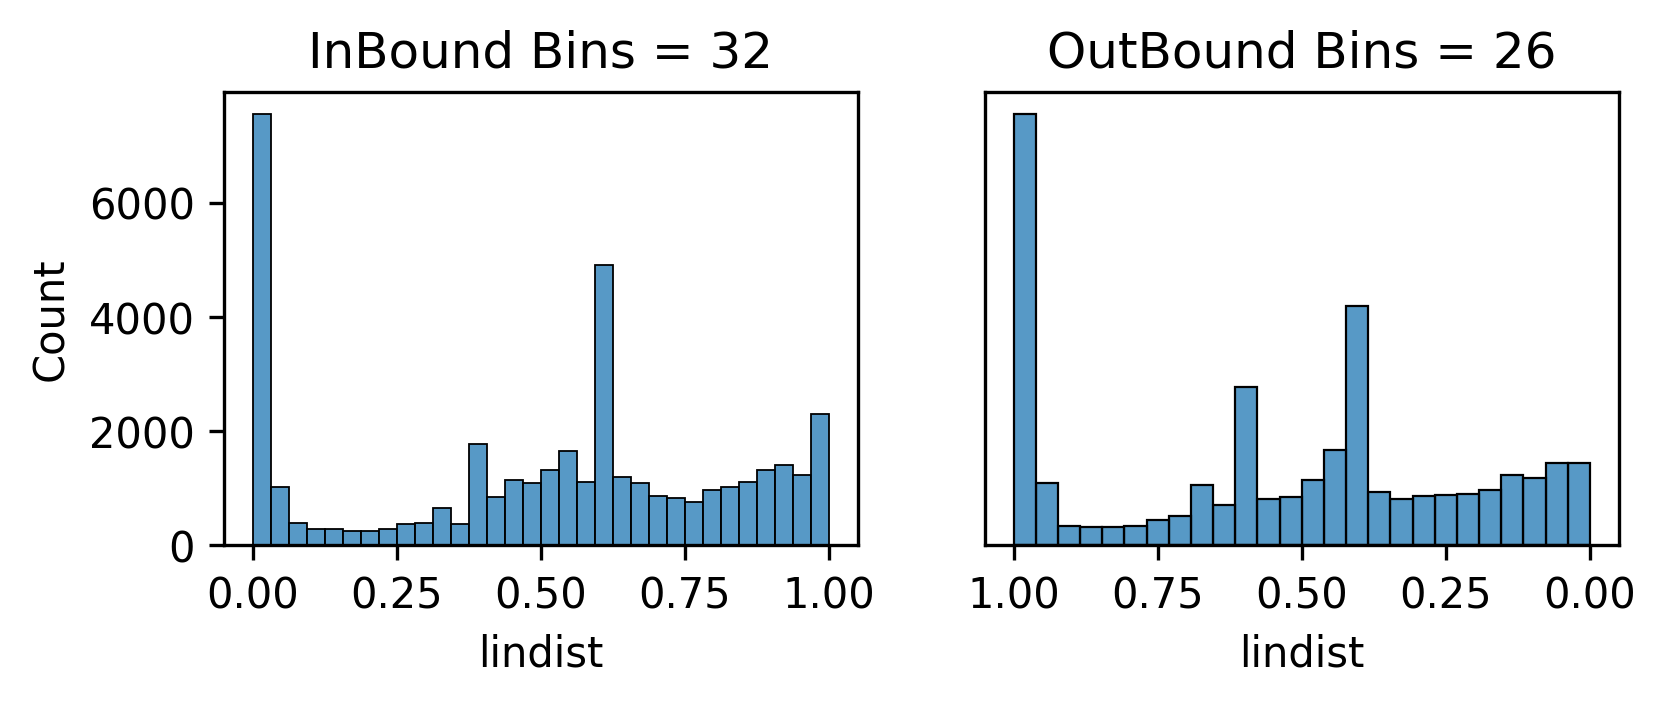

In [ ]:
df = pd.read_csv("F:/ComSub/code/ComSub-master/mytry/behsample.csv")

df['trajectory_type'] = df['trajclass']

trial_times = df.groupby('trajall')['time'].agg(['min', 'max'])

df = df.join(trial_times, on='trajall', how='left')

# Calculate 'percent_time_progress'
df['percent_time_progress'] = (df['time'] - df['min']) / (df['max'] - df['min'])

fig = plt.figure(figsize=(6,2), dpi=300)
ax1 = fig.add_subplot(1,2,1)
norm_dist = df.query('abs(vel) > 5 & trajbound == 1')['lindist']
q1 = norm_dist.quantile(0.25)
q3 = norm_dist.quantile(0.75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(norm_dist) ** (1 / 3))
bin_count = int(np.ceil((norm_dist.max() - norm_dist.min()) / bin_width))
sns.histplot(x=norm_dist,bins=bin_count)
ax1.set_title(f'InBound Bins = {bin_count}')

ax2 = fig.add_subplot(1,2,2)
norm_dist = df.query('abs(vel) > 5 & trajbound == 0')['lindist']
q1 = norm_dist.quantile(0.25)
q3 = norm_dist.quantile(0.75)
iqr = q3 - q1
bin_width = (2 * iqr) / (len(norm_dist) ** (1 / 3))
bin_count = int(np.ceil((norm_dist.max() - norm_dist.min()) / bin_width))
sns.histplot(x=norm_dist,bins=bin_count)
ax2.set_title(f'OutBound Bins = {bin_count}')
ax2.set_ylabel('')
ax2.set_yticks([])
ax2.invert_xaxis()


df = df.query('abs(vel) > 5')
# Create 100 bins for 'percent_time_progress'
df['lindist_binned'] = pd.cut(df['lindist'], bins = 36, labels=False)

templates = df.groupby(['trajectory_type', 'lindist_binned'])[['X', 'Y']].median().reset_index()

df.head()


array([[<AxesSubplot:title={'center':'lindist'}>]], dtype=object)

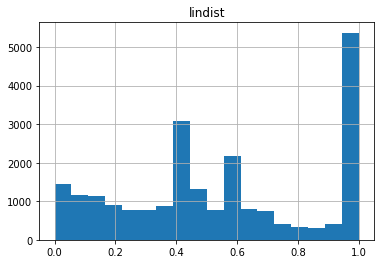

In [117]:
df.query('abs(vel) > 5 & trajbound == 0 & rewarded == 1').hist("lindist", bins= 18)

In [ ]:
## create templates_smoothed

from scipy.signal import savgol_filter

templates_smoothed = pd.DataFrame()

# Apply Savitzky-Golay smoothing to each trajectory type
for traj_type in templates['trajectory_type'].unique():
    traj_data = templates[templates['trajectory_type'] == traj_type].copy()
    traj_data['X'] = savgol_filter(traj_data['X'], 5, 2) # window size 5, polynomial order 2
    traj_data['Y'] = savgol_filter(traj_data['Y'], 5, 2) # window size 5, polynomial order 2
    templates_smoothed = templates_smoothed.append(traj_data)

templates_smoothed.head()


,trajectory_type,time_binned,X,Y
0,1,0,65.387207,84.209043
1,1,1,72.680122,71.798226
2,1,2,76.717011,59.192919
3,1,3,76.226888,46.365209
4,1,4,75.828649,32.473464


Functions

In [ ]:
'''
# version 1
from tqdm import tqdm

def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts):
    # Initialize a dictionary to hold the aligned spike counts for each trajectory type
    aligned_counts = {i: [None]*100 for i in range(1, 5)}
    X_collected = {i: [] for i in range(1, 5)}
    Y_collected = {i: [] for i in range(1, 5)}
    T_collected = {i: [] for i in range(1, 5)}

    f = interp1d(time_of_spikecounts, spikeCountMatrix, axis=0, bounds_error=False, fill_value="extrapolate")

    # Group the DataFrame by trajectory type and trial ID
    for (traj_type, trajall), group in tqdm(df.groupby(['trajectory_type', 'trajall']), desc="Processing items", ncols=100):
        template = templates[templates['trajectory_type'] == traj_type][['X', 'Y']].values

        trial = group[['X', 'Y']].values
        trial_times = group['time'].values

        _, path = fastdtw(trial, template, dist=euclidean)

        X = []
        Y = []
        
        for any in path:
            X = [*X, trial[any[0]][0]]
            Y = [*Y, trial[any[0]][1]]
        X_collected[traj_type] = [*X_collected[traj_type], X]
        Y_collected[traj_type] = [*Y_collected[traj_type], Y]

        bin_to_indices = {i: [] for i in range(100)}
        for trial_idx, template_idx in path:
            bin_to_indices[template_idx].append(trial_idx)

        T = []
        for trial_idx, template_idx in path:
            T = [*T, template_idx]
        T_collected[traj_type] = [*T_collected[traj_type], T]

        for bin_idx, trial_indices in bin_to_indices.items():
            behavior_times = group.iloc[trial_indices]['time'].values
            
            spike_counts_bin = f(behavior_times)
            if aligned_counts[traj_type][bin_idx] is None:
                aligned_counts[traj_type][bin_idx] = spike_counts_bin
            else:
                aligned_counts[traj_type][bin_idx] = np.concatenate([aligned_counts[traj_type][bin_idx], spike_counts_bin], axis=0)

    return aligned_counts, X_collected, Y_collected, T_collected
'''

In [ ]:
# (OPTIONAL) version 2
from tqdm import tqdm
import random

def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts, n_points_per_bin):
#def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts, n_points_per_bin, move_threshold):
    aligned_counts = {i: [None]*100 for i in range(1, 5)}
    X_collected = {i: [] for i in range(1, 5)}
    Y_collected = {i: [] for i in range(1, 5)}
    T_collected = {i: [] for i in range(1, 5)}

    f = interp1d(time_of_spikecounts, spikeCountMatrix, axis=0, bounds_error=False, fill_value="extrapolate")

    for (traj_type, trajall), group in tqdm(df.groupby(['trajectory_type', 'trajall']), desc="Processing items", ncols=100):
        template = templates[templates['trajectory_type'] == traj_type][['X', 'Y']].values

        trial = group[['X', 'Y']].values

        _, path = fastdtw(trial, template, dist=euclidean)

        '''
        # Calculate the total change in the X and Y coordinates along the path
        total_change = np.sum(np.abs(np.diff(trial[[p[0] for p in path]], axis=0)))

        # If the total change is below the threshold, discard this path
        if total_change < move_threshold:
            continue
        '''

        X_trial = []
        Y_trial = []
        T_trial = []

        # Create a mapping from template bins to trial indices
        bin_to_indices = {i: [] for i in range(100)}
        for trial_idx, template_idx in path:
            bin_to_indices[template_idx].append(trial_idx)

        max_elements = max([max(sublist) for sublist in bin_to_indices.values()])
        if max_elements < 100:
            continue


        for bin_idx, trial_indices in bin_to_indices.items():

            if len(trial_indices) > n_points_per_bin:
                trial_indices = random.sample(trial_indices, n_points_per_bin)
            else:
                # Interpolate 
                trial_indices = np.interp(
                    np.linspace(0, len(trial_indices) - 1, n_points_per_bin),
                    np.arange(len(trial_indices)),
                    trial_indices
                )

            behavior_times = group.iloc[trial_indices]['time'].values

            spike_counts_bin = f(behavior_times)
 
            if aligned_counts[traj_type][bin_idx] is None:
                aligned_counts[traj_type][bin_idx] = spike_counts_bin
            else:
                aligned_counts[traj_type][bin_idx] = np.concatenate([aligned_counts[traj_type][bin_idx], spike_counts_bin], axis=0)

            X_trial.append(group.iloc[trial_indices]['X'].values)
            Y_trial.append(group.iloc[trial_indices]['Y'].values)
            T_trial.append([bin_idx] * len(trial_indices))

        X_collected[traj_type].append(X_trial)
        Y_collected[traj_type].append(Y_trial)
        T_collected[traj_type].append(T_trial)

    return aligned_counts, X_collected, Y_collected, T_collected





In [ ]:
# version 3
from tqdm import tqdm

def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts):
#def align_trials(df, templates, spikeCountMatrix, time_of_spikecounts, n_points_per_bin, move_threshold):
    aligned_counts = {i: [None]*36 for i in range(1, 5)}
    aligned_counts_T = {i: [None]*36 for i in range(1, 5)}
    aligned_counts_X = {i: [None]*36 for i in range(1, 5)}
    aligned_counts_Y = {i: [None]*36 for i in range(1, 5)}

    f = interp1d(time_of_spikecounts, spikeCountMatrix, kind = "nearest", axis=0)

    # Group the DataFrame by trajectory type and trial ID
    for (traj_type, trajall), group in tqdm(df.groupby(['trajectory_type', 'trajall']), desc="Processing items", ncols=100):

        template = templates[templates['trajectory_type'] == traj_type][['X', 'Y']].values

        trial = group[['X', 'Y']].values

        _, path = fastdtw(trial, template, dist=euclidean)

        '''
        # Calculate the total change in the X and Y coordinates along the path
        total_change = np.sum(np.abs(np.diff(trial[[p[0] for p in path]], axis=0)))

        # If the total change is below the threshold, discard this path
        if total_change < move_threshold:
            continue
        '''

        # Create a mapping from template bins to trial indices
        bin_to_indices = {i: [] for i in range(36)}
        for trial_idx, template_idx in path:
            bin_to_indices[template_idx].append(trial_idx)
        
        #clear the path, remove path with less than 50 points, which might be rats stopping in the halfway
        max_elements = max([max(sublist) for sublist in bin_to_indices.values()])
        if max_elements < 36:
            continue

        for bin_idx, trial_indices in bin_to_indices.items():

            behavior_times = group.iloc[trial_indices]['time'].values
            x = group.iloc[trial_indices]['X'].values
            y = group.iloc[trial_indices]['Y'].values
            spike_counts_bin = f(behavior_times)
            
            spike_counts_bin = np.median(spike_counts_bin, axis=0)
       
            if aligned_counts[traj_type][bin_idx] is None:
                aligned_counts[traj_type][bin_idx] = spike_counts_bin
                aligned_counts_T[traj_type][bin_idx] = behavior_times.tolist()
                aligned_counts_X[traj_type][bin_idx] = x.tolist()
                aligned_counts_Y[traj_type][bin_idx] = y.tolist()
            else:
                aligned_counts[traj_type][bin_idx] = np.vstack((aligned_counts[traj_type][bin_idx], spike_counts_bin))
                aligned_counts_T[traj_type][bin_idx] = aligned_counts_T[traj_type][bin_idx] + behavior_times.tolist()
                aligned_counts_X[traj_type][bin_idx] = aligned_counts_X[traj_type][bin_idx] + x.tolist()
                aligned_counts_Y[traj_type][bin_idx] = aligned_counts_Y[traj_type][bin_idx] + y.tolist()
    return aligned_counts, aligned_counts_T, aligned_counts_X, aligned_counts_Y

Version 3

In [ ]:
aligned_counts, aligned_counts_T, aligned_counts_X, aligned_counts_Y = align_trials(df, templates_smoothed, spikeCountMatrix, time_of_spikecounts)


Processing items: 100%|███████████████████████████████████████████| 612/612 [00:36<00:00, 16.85it/s]


In [103]:
for i in range(20,36):

    print(len(aligned_counts_X[1][i])) 

265
134
104
90
90
97
100
124
561
454
352
588
2557
193
221
484


In [85]:
# (Optional) if use version 3 to plot time bins, do this
def center_n(a,b,n):
    
    distances = np.sqrt((a - np.median(a))**2 + (b - np.median(b))**2)

    center_n_indices = np.argpartition(distances, n)[:n]

    center_n_points_a = a[center_n_indices]
    center_n_points_b = b[center_n_indices]

    return center_n_points_a, center_n_points_b, center_n_indices

In [104]:
# (Optional) if use version 3 to plot time bins, do this
for i in range(1,5):
    x = aligned_counts_X[i]
    y = aligned_counts_Y[i]
    t = aligned_counts_T[i]

    for j in range(len(x)):
        x_path, y_path, inx = center_n(np.array(x[j]), np.array(y[j]), 80)
        t_path = np.array(t[j])[inx]
        aligned_counts_X[i][j] = x_path
        aligned_counts_Y[i][j] = y_path
        aligned_counts_T[i][j] = t_path

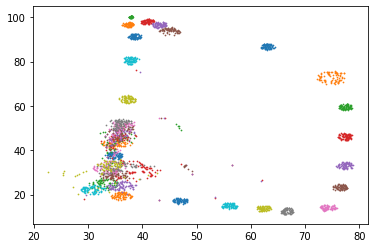

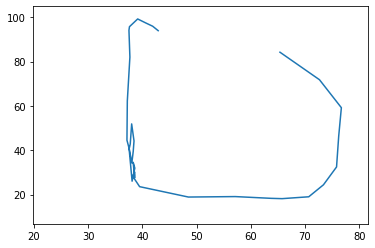

In [105]:
# (Optional) if use version 3 to plot time bins, do this
import matplotlib.pyplot as plt

X1 = aligned_counts_X[1]
Y1 = aligned_counts_Y[1]

assert len(X1) == len(Y1)

fig1 = plt.figure()

for i in range(len(X1)):

    x_path = X1[i]
    y_path = Y1[i]

    assert len(x_path) == len(y_path)

    plt.scatter(x_path, y_path, s=0.5)

# get the lims of the first figure
xlim1 = plt.xlim()
ylim1 = plt.ylim()

plt.show()

plt.figure()
template = templates_smoothed[templates_smoothed['trajectory_type'] == 1][['X', 'Y']].values
x_template = template[:, 0]
y_template = template[:, 1]

assert len(x_template) == len(y_template)

plt.plot(x_template, y_template)

plt.xlim(xlim1)
plt.ylim(ylim1)

plt.show()

In [108]:
# (Optional) if use version 3 to plot time bins and save reults, do this
f = interp1d(time_of_spikecounts, spikeCountMatrix, kind = "nearest", axis=0)

aligned_counts_now = {}
aligned_counts_now["in_left"] = []
aligned_counts_now["in_right"] = []
aligned_counts_now["out_left"] = []
aligned_counts_now["out_right"] = []

for i in range(1,5):
    Times = aligned_counts_T[i]
    Spikes = [[] for any in range(36)]
    for j in range(36):
        Times_for_bin = np.sort(Times[j])
        spike_counts_bin = f(Times_for_bin)
        Spikes[j] = spike_counts_bin
    aligned_counts_now[list(aligned_counts_now.keys())[i-1]] = np.array(Spikes)

aligned_counts_now["in_left"].shape

(36, 80, 224)

In [20]:
# (Optional) if directly use version 3, do this
aligned_counts_now = {}
aligned_counts_now["in_left"] = []
aligned_counts_now["in_right"] = []
aligned_counts_now["out_left"] = []
aligned_counts_now["out_right"] = []

for key in aligned_counts.keys():
    
    aligned_counts_now[list(aligned_counts_now.keys())[key-1]] = np.array([matrix for matrix in aligned_counts[key] if not np.all(np.isnan(matrix))])

print(aligned_counts_now["in_left"].shape)

(30, 115, 224)


In [109]:
# save 
from scipy.io import savemat

savemat('F:/ComSub/code/ComSub-master/mytry/aligned_spikeCountTensor.mat', aligned_counts_now)

(OPTIONAL) check fun_version 2: only used to plot the path

In [109]:
# (OPTIONAL) check fun_version 2: only used to plot the path
aligned_counts, X_collected, Y_collected, T_collected = align_trials(df, templates_smoothed, spikeCountMatrix, time_of_spikecounts, n_points_per_bin=2)


Processing items: 100%|███████████████████████████████████████████| 617/617 [01:56<00:00,  5.29it/s]


In [110]:
# (Optional) if use version 2 to plot path, do this
X_collected2 = {i: [] for i in range(1, 5)}
Y_collected2 = {i: [] for i in range(1, 5)}
T_collected2 = {i: [] for i in range(1, 5)}

for i in range(1,5):
    X_collected2[i] = [np.hstack(X_collected[i][j]) for j in range(len(X_collected[i]))]
    Y_collected2[i] = [np.hstack(Y_collected[i][j]) for j in range(len(Y_collected[i]))]
    T_collected2[i] = [np.hstack(T_collected[i][j]) for j in range(len(T_collected[i]))]

In [16]:
# (Optional) if to store the result of version 2, do this
aligned_counts_now = {}
aligned_counts_now["in_left"] = []
aligned_counts_now["in_right"] = []
aligned_counts_now["out_left"] = []
aligned_counts_now["out_right"] = []

for key in aligned_counts.keys():
    
    aligned_counts_now[list(aligned_counts_now.keys())[key-1]] = np.array([matrix for matrix in aligned_counts[key] if not np.all(np.isnan(matrix))])

print(aligned_counts_now["in_left"].shape)

(100, 91, 224)


In [50]:
# (Optional) if to save the result of version 2, do this
from scipy.io import savemat

savemat('F:/ComSub/code/ComSub-master/mytry/aligned_spikeCountTensor.mat', aligned_counts_now)


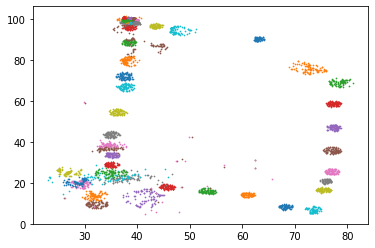

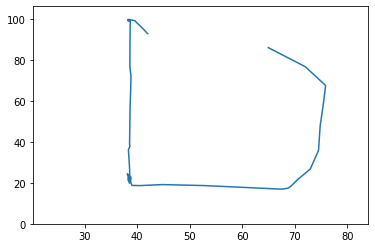

In [49]:
# 2D plot of version 2

import matplotlib.pyplot as plt

X1 = X_collected2[1] #1, 2, 3, 4 are the keys corresponding to 44 traj_type
Y1 = X_collected2[1]

assert len(X1) == len(Y1)

fig1 = plt.figure()

for i in range(len(X1)):

    x_path = X1[i]
    y_path = Y1[i]

    assert len(x_path) == len(y_path)

    plt.scatter(x_path, y_path, s=0.5)

# get the lims of the first figure
xlim1 = plt.xlim()
ylim1 = plt.ylim()

plt.show()

plt.figure()
template = templates_smoothed[templates_smoothed['trajectory_type'] == 1][['X', 'Y']].values # if change keys, remember to change templates_smoothed['trajectory_type'] == 1
x_template = template[:, 0]
y_template = template[:, 1]

assert len(x_template) == len(y_template)

plt.plot(x_template, y_template)

plt.xlim(xlim1)
plt.ylim(ylim1)

plt.show()

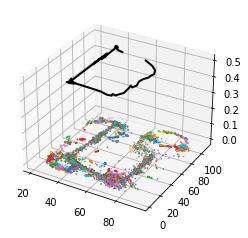

In [11]:
# plot for version 2: template and path together

template = templates_smoothed[templates_smoothed['trajectory_type'] == 1][['X', 'Y']].values
X1 = X_collected2[1]
Y1 = Y_collected2[1]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(X1)):

    x_path = X1[i]
    y_path = Y1[i]
    z_path = [0]*len(x_path)  

    assert len(x_path) == len(y_path) == len(z_path)

    ax.scatter(x_path, y_path, z_path, s=0.5)

x_template = template[:, 0]
y_template = template[:, 1]
z_template = [0.5]*len(x_template)  

assert len(x_template) == len(y_template) == len(z_template)

ax.plot(x_template, y_template, z_template, color='k', linewidth=2) 

plt.show()


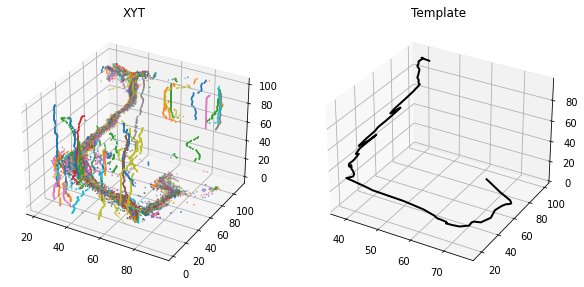

In [111]:
# 3D plot of version 2

template = templates_smoothed[templates_smoothed['trajectory_type'] == 1][['X', 'Y', 'percent_time_progress_binned']].values
X1 = aligned_counts_X[1]
Y1 = aligned_counts_Y[1]
T1 = T_collected2[1]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 5))

ax1 = fig.add_subplot(121, projection='3d')

for i in range(len(X1)):
    x_path = X1[i]
    y_path = Y1[i]
    z_path = T1[i] 

    assert len(x_path) == len(y_path) == len(z_path)

    ax1.scatter(x_path, y_path, z_path, s=0.5)

ax1.set_title('XYT')

ax2 = fig.add_subplot(122, projection='3d')

x_template = template[:, 0]
y_template = template[:, 1]
z_template = template[:, 2]  

assert len(x_template) == len(y_template) == len(z_template)

ax2.plot(x_template, y_template, z_template, color='k', linewidth=2)  

ax2.set_title('Template')

plt.show()
